<a href="https://colab.research.google.com/github/salsabillaflsft/ABSApublic/blob/main/theinnerworkings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformers - BERT - IndoBERT**

## Installation

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.0 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from transformers import BertTokenizer, BertConfig, BertForPreTraining, BertPreTrainedModel, BertModel

import itertools
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

## Load Data

Dataset 

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/TA/Dataset

Mounted at /content/drive
/content/drive/My Drive/TA/Dataset


In [4]:
dataset_folder_path = '/content/drive/MyDrive//TA/Dataset'

In [5]:
train_dataset_path = dataset_folder_path + '/train_preprocess_70.csv'
valid_dataset_path = dataset_folder_path + '/val_preprocess_15.csv'
test_dataset_path = dataset_folder_path + '/test_preprocess_15.csv'

In [6]:
#example 11-3-4-5-6
data = [
    "Tempatnya asyik utk nyantai bareng teman2 ,  walau gang masuk nya sempit .  Mobil parkir di jalan besar .",
    "Tempatnya enak ,  menunya enak tp pegawainya kok songong yaa .  Kapok sih ,  ga bakalan ke sana lagi",
    "Tempat nongkrong jaman maba banget nyaman sih buat nugas",
    "Agak panas dan tumben penuh padahal siang2 kesana",
    "Cocok kalo untuk kerja atau nugas",
]

# labels = ["positive,	neutral,	neutral,	neutral,	neutral,	positive",
#           "negative,	negative,	positive,	neutral,	neutral,	positive",
#           "positive,	neutral,	neutral,	neutral,	neutral,	positive",
#           "positive,	neutral,	neutral,	neutral,	negative,	neutral",
#           "positive,	neutral,	neutral,	neutral,	neutral,	positive",
#           ]

aspects = ['umum','layanan','menu','harga','fasilitas','suasana']

labels = [[2,	1,	1,	1,	1,	2],
          [0,	0,	2,	1,	1,	2],
          [2,	1,	1,	1,	1,	2],
          [2,	1,	1,	1,	0,	1],
          [2,	1,	1,	1,	1,	2],
          ]

## Modules (dataset)

In [7]:
class AspectBasedSentimentAnalysisDataset(Dataset):
    # Static constant variable
    ASPECT_DOMAIN = ['umum','layanan','menu','harga','fasilitas','suasana']
    LABEL2INDEX = {'negative': 0, 'neutral': 1, 'positive': 2}
    INDEX2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}
    NUM_LABELS = [3, 3, 3, 3, 3, 3]
    NUM_ASPECTS = 6
    
    def load_dataset(self, path):
        df = pd.read_csv(path)
        for aspect in self.ASPECT_DOMAIN:
            df[aspect] = df[aspect].apply(lambda sen: self.LABEL2INDEX[sen])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
        
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        sentence, labels = data['review_text'], [data[aspect] for aspect in self.ASPECT_DOMAIN]
        subwords = self.tokenizer.encode(sentence, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['review_text']
    
    def __len__(self):
        return len(self.data)

class AspectBasedSentimentAnalysisDataLoader(DataLoader):
    def __init__(self, dataset, max_seq_len=512, *args, **kwargs):
        super(AspectBasedSentimentAnalysisDataLoader, self).__init__(dataset=dataset, *args, **kwargs)
        self.num_aspects = dataset.NUM_ASPECTS
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        label_batch = np.zeros((batch_size, self.num_aspects), dtype=np.int64)

        seq_list = []
        
        for i, (subwords, label, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            label_batch[i,:] = label

            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, label_batch, seq_list

MultiLabel

In [8]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels_list

        self.bert = BertModel(config)  #bert model layer
        self.dropout = nn.Dropout(config.hidden_dropout_prob)  #bert dropout layer
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, num_label) for num_label in self.num_labels]) #bert classification layer

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            total_loss = 0
            for i, (logit, num_label) in enumerate(zip(logits, self.num_labels)):
                label = labels[:,i]
                loss = loss_fct(logit.view(-1, num_label), label.view(-1))
                total_loss += loss
            outputs = (total_loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)

## Load Model, Tokenizer, Config

In [9]:
# Load Tokenizer, Config, Model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')

config.num_labels = max(AspectBasedSentimentAnalysisDataset.NUM_LABELS)
config.num_labels_list = AspectBasedSentimentAnalysisDataset.NUM_LABELS
model = BertForMultiLabelClassification.from_pretrained('indobenchmark/indobert-base-p1',config=config)

Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifiers.5.bias', 'classifiers.1.weight', 'classifiers.4.bias', 'classifiers.2.weight', 'classifiers.2.bias', 'classifiers.1.bias', 'classifiers.0.bias', 'classifiers.0.weight', 'classifiers.3.bias', 'classifiers.5.weight', 'classifiers.3.weight', 'classifiers.4.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
print('NUMBER OF LAYERS:', config.num_hidden_layers)

print('EMBEDDING SIZE:', config.hidden_size)

print('ACTIVATIONS:', config.hidden_act)

NUMBER OF LAYERS: 12
EMBEDDING SIZE: 768
ACTIVATIONS: gelu


In [11]:
model

BertForMultiLabelClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [12]:
train_dataset = AspectBasedSentimentAnalysisDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = AspectBasedSentimentAnalysisDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = AspectBasedSentimentAnalysisDataset(test_dataset_path, tokenizer, lowercase=True)

In [13]:
train_loader = AspectBasedSentimentAnalysisDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=True)  
valid_loader = AspectBasedSentimentAnalysisDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=False)  
test_loader = AspectBasedSentimentAnalysisDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=False)

## Pre-Processing - Tokenizer - WordPiece

tokenization, token to ids, special tokens, label *encoding*, padding truncating, att masks

WordPiece tokenization - the inner workings -> [wordpiece inner workings](https://colab.research.google.com/drive/1LYVJDlsFje9DNUvpS1gQybpbN9j7NrHb?usp=sharing)

In [99]:
input_sequences = tokenizer(text=data, add_special_tokens=True, padding=True, truncation=True, return_tensors='pt')
input_sequences.update({'labels':torch.tensor(labels)})

[print('%s : %s\n'%(k,v)) for k,v in input_sequences.items()];

input_ids : tensor([[    2,  7229,  8181,  4302,  1107, 12006,    94,  8074,  1614, 30378,
         30468,  1766, 10357,   804,  1107,  7132, 30470,   895,  5222,    26,
           795,   421, 30470,     3,     0],
        [    2,  7229,  3107, 30468,  1622,    57,  3107,  3478,  3027,    57,
          2105, 30052,  2692,  5633, 30470,  1012,   118,  1966, 30468,   525,
         10263,    43,  2377,   423,     3],
        [    2,   515, 16503,  4881,  6943, 30354,  2174,  2382,  1966,   968,
         19287,    22,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [    2,  2839,  1990,    41,  1349,  1771,  1876,  2234,  3346, 30378,
         11105,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [    2,  2040,  1686,    90,   494,   158, 19287,    22,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [100]:
[print(tokenizer.decode(example)) for example in input_sequences['input_ids'].numpy()];

[CLS] tempatnya asyik utk nyantai bareng teman2, walau gang masuk nya sempit. mobil parkir di jalan besar. [SEP] [PAD]
[CLS] tempatnya enak, menunya enak tp pegawainya kok songong yaa. kapok sih, ga bakalan ke sana lagi [SEP]
[CLS] tempat nongkrong jaman maba banget nyaman sih buat nugas [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] agak panas dan tumben penuh padahal siang2 kesana [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] cocok kalo untuk kerja atau nugas [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


### result based on all data

In [101]:
# example on pre-processing based on all data
train_dataset[9]

(array([    2,  7229,  8181,  4302,  1107, 12006,    94,  8074,  1614,
        30378, 30468,  1766, 10357,   804,  1107,  7132, 30470,   895,
         5222,    26,   795,   421, 30470,     3]),
 array([2, 1, 1, 1, 1, 2]),
 'Tempatnya asyik utk nyantai bareng teman2 ,  walau gang masuk nya sempit .  Mobil parkir di jalan besar .')

In [102]:
# Get an iterator for the train_loader
train_iter = iter(train_loader)

# Get the first batch of data
batch_data = next(train_iter)

In [103]:
batch_data # this shows the token to ids(padded to same length, special tokens added), attention masks, label(encoded), the data)

(array([[    2,  2382,   684, ...,   811, 30457,     3],
        [    2,  4824, 11123, ...,     0,     0,     0],
        [    2,  1990,  2174, ...,     0,     0,     0],
        ...,
        [    2,  2382, 11277, ...,     0,     0,     0],
        [    2,   515, 20883, ...,     0,     0,     0],
        [    2,  2476,    41, ...,     0,     0,     0]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]], dtype=float32),
 array([[2, 2, 1, 1, 0, 2],
        [2, 2, 2, 1, 1, 1],
        [0, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0],
        [2, 1, 1, 1, 1, 1],
        [2, 1, 2, 1, 1, 1],
        [2, 1, 2, 1, 1, 2],
        [2, 1, 1, 1, 1, 2],
        [2, 1, 1, 1, 1, 2],
        [2, 1, 1, 0, 0, 2],
        [1, 0, 1, 1, 0, 2],
        [2, 1, 1, 1, 1, 2],
        [2, 1, 2, 1, 0, 2],
        [2, 1, 

## BERT Embedding: Token - Segment - Position

In [104]:
# class Embeddings(nn.Module):
#     def __init__(self, d_model, vocab):
#         super(Embeddings, self).__init__()
#         self.lut = nn.Embedding(vocab, d_model)
#         self.d_model = d_model

#     def forward(self, x):
#         return self.lut(x) * math.sqrt(self.d_model)

### PE

positional encoding/embedding
- transformer takes all the embedding at once
- filling with the words order will distort the infos
- added normalization will confuse the model

PE -> used frequencies to capture data infos


PE(𝑝𝑜𝑠,2𝑖)=𝑠𝑖𝑛(𝑝𝑜𝑠/(10000 x 2𝑖/𝑑𝑚𝑜𝑑𝑒𝑙))
 
PE(𝑝𝑜𝑠,2𝑖+1)=𝑐𝑜𝑠(𝑝𝑜𝑠/(10000 x 2𝑖/𝑑𝑚𝑜𝑑𝑒𝑙))

pos = position of the word (max sequence length = 512)(in this, length of tokens = 25)

i = indices, dimensions of the embedding (768)

dmodel = dimension/size of the embedding 
(BERT embedding size -> 768) 

with this formulas/calculation, each word with diff positions will have different position embeddings values


In [105]:
# class PositionalEncoding(nn.Module):
#     "Implement the PE function."

#     def __init__(self, d_model, dropout, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         # Compute the positional encodings once in log space.
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer("pe", pe)

#     def forward(self, x):
#         x = x + self.pe[:, : x.size(1)].requires_grad_(False)
#         return self.dropout(x)

In [106]:
# def show_example(fn, args=[]):
#     if __name__ == "__main__":
#         return fn(*args)

# def example_positional():
#     pe = PositionalEncoding(20, 0)
#     y = pe.forward(torch.zeros(1, 100, 20))

#     data = pd.concat(
#         [
#             pd.DataFrame(
#                 {
#                     "embedding": y[0, :, dim],
#                     "dimension": dim,
#                     "position": list(range(100)),
#                 }
#             )
#             for dim in [4, 5, 6, 7]
#         ]
#     )

#     return (
#         alt.Chart(data)
#         .mark_line()
#         .properties(width=800)
#         .encode(x="position", y="embedding", color="dimension:N")
#         .interactive()
#     )


# show_example(example_positional)

In [107]:
# #for pos embedding visualizations, include pos encoding formulas
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# def pos_visualize(position_embeddings):
#     # Extract the shape of the position embeddings.
#     _, pos, d_model = position_embeddings.shape #[1,25,78]
    
#     even_i = np.arange(0, d_model, 2, dtype='int')
#     odd_i = np.arange(1, d_model, 2, dtype='int')
#     pe_1 = []
#     pe_2 = []

#     for _pos in range(pos):
#         pe_even = np.sin(_pos / np.power(10000, (2 * even_i / d_model)))
#         pe_odd = np.cos(_pos / np.power(10000, (2 * odd_i / d_model)))
#         pe_1.append(np.insert(pe_even, list(range(1, len(pe_odd) + 1)), pe_odd))
#         pe_2.append(np.concatenate([pe_even, pe_odd]))

#     # Create heatmaps to visualize the positional embeddings.
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     sns.heatmap(pe_1, cmap='GnBu')
#     plt.title('Sine Positional Embeddings')
#     plt.xlabel('Embedding Dimension')
#     plt.ylabel('Position')
#     plt.subplot(1, 2, 2)
#     sns.heatmap(pe_2, cmap='GnBu')
#     plt.title('Cosine Positional Embeddings')
#     plt.xlabel('Embedding Dimension')
#     plt.ylabel('Position')
#     plt.tight_layout()
#     plt.show()

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def pos_visualize(position_embeddings):
    # Extract the shape of the position embeddings.
    _, pos, d_model = position_embeddings.shape 
    
    # Compute the positional encodings.
    pe = np.zeros((pos, d_model))
    for pos_idx in range(pos):
        for i in range(0, d_model):
            if i % 2 == 0:
                pe[pos_idx, i] = np.sin(pos_idx / (10000 ** (i / d_model)))
            else:
                pe[pos_idx, i] = np.cos(pos_idx / (10000 ** ((i-1) / d_model)))
    
    # Plot the positional encodings.
    plt.figure(figsize=(10, 5))
    sns.heatmap(pe, cmap='GnBu')
    plt.title('Positional Embeddings')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.tight_layout()
    plt.show()

### Results

Created Tokens Positions IDs:
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24]])

Tokens IDs shape:
 torch.Size([5, 25])

Tokens IDs:
 tensor([[    2,  7229,  8181,  4302,  1107, 12006,    94,  8074,  1614, 30378,
         30468,  1766, 10357,   804,  1107,  7132, 30470,   895,  5222,    26,
           795,   421, 30470,     3,     0],
        [    2,  7229,  3107, 30468,  1622,    57,  3107,  3478,  3027,    57,
          2105, 30052,  2692,  5633, 30470,  1012,   118,  1966, 30468,   525,
         10263,    43,  2377,   423,     3],
        [    2,   515, 16503,  4881,  6943, 30354,  2174,  2382,  1966,   968,
         19287,    22,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [    2,  2839,  1990,    41,  1349,  1771,  1876,  2234,  3346, 30378,
         11105,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0

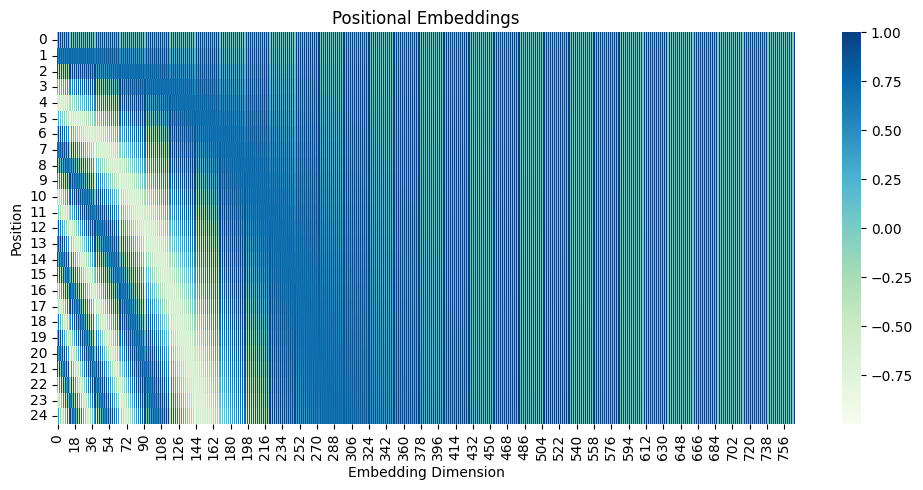


Token Types Embeddings:
 torch.Size([5, 25, 768])

Token Types Embeddings:
 tensor([[[-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         ...,
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758]],

        [[-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         ...,
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758],
         [-0.2710,  0.2428, -0.2784,  ...,  1.1025,  0.7930,  1.3758]],

        [[-0.2710,  0.2428, -0.2784,  .

In [109]:
class BertEmbeddings(torch.nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = torch.nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = torch.nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = torch.nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load any TensorFlow checkpoint file
        self.LayerNorm = torch.nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")

    def forward(
        self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]

        print('Created Tokens Positions IDs:\n', position_ids)        

        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # Inputs IDS
        print('\nTokens IDs shape:\n', input_ids.shape)
        print('\nTokens IDs:\n', input_ids)
        # Segment Embedding
        print('\nTokens Type IDs shape:\n', token_type_ids.shape)
        print('\nTokens Type IDs / Segments:\n', token_type_ids)
        # Token Embedding
        print('\nWord Embeddings shape:\n', inputs_embeds.shape)
        print('\nWord Embeddings #1:\n', inputs_embeds)


        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)

            # Position Embedding
            print('\nPosition Embeddings:\n', position_embeddings.shape)
            print('\nPosition Embeddings:\n', position_embeddings)
            embeddings += position_embeddings
            pos_visualize(position_embeddings)

        print('\nToken Types Embeddings:\n', token_type_embeddings.shape)
        print('\nToken Types Embeddings:\n', token_type_embeddings)
        
        print('\nSum Up All Embeddings:\n', embeddings.shape)
        print('\nResult:\n', embeddings)

        embeddings = self.LayerNorm(embeddings)

        print('\nEmbeddings Layer Normalization:\n', embeddings.shape)

        embeddings = self.dropout(embeddings)

        print('\nEmbeddings Dropout Layer:\n', embeddings.shape)
        
        return embeddings


# Create Bert embedding layer.
bert_embeddings_block = BertEmbeddings(config)

# Perform a forward pass.
embedding_output = bert_embeddings_block.forward(input_ids=input_sequences['input_ids'], token_type_ids=input_sequences['token_type_ids'])

## Encoder #1 Attention: Self-Attention - Multi-Head Attention

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

result

In [ ]:
def viz_encoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[
        len(example_data) - 1
    ]  # batch object for the final example

    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(example[1]), example[1], example[1]
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        # & layer_viz[1]
        & layer_viz[2]
        # & layer_viz[3]
        & layer_viz[4]
        # & layer_viz[5]
    )


show_example(viz_encoder_self)

## Add + Norm

## Encoder #2 Feed Forward NN

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

## sources and more

[transformers inner workings](http://nlp.seas.harvard.edu/annotated-transformer/#positional-encoding)

[bert inner workings](https://gmihaila.github.io/tutorial_notebooks/bert_inner_workings/)


[bert visualization](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing)